# Reproducing the results in Figure 5 
A quantification of explanation quality with gradual feature occlusion

To get the results of this notebook, you should first execute ``retrain_{DS_NAME}_example.ipynb`` to produce necessary materials for the quantiative evaluation implemented here. These materials include:
- The to-be-explained model
- The structured data folder
- The strucutred explanation folder, with each explanation file named by the unique data sample id.

Please make sure that you have generated explanations using VG, SG, and IG by configuring the ``EXPL_NAME`` variable, which are mandatory for a quantitative comparison.

In [1]:
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import os, pickle, argparse, random
import torch, torchvision
from torch import nn
import matplotlib.pyplot as plt

from utils import basic
from utils.basic import log
from utils import train_engine as tre
from utils import data_process as dp

from timm.utils import NativeScaler
from timm.scheduler import create_scheduler
from timm.optim import create_optimizer
from tqdm import tqdm

# For visualization
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import TwoSlopeNorm, Normalize
import matplotlib.gridspec as gridspec
plt.rc('text', usetex=True), plt.rc('font', size=25), plt.rc('xtick', labelsize=10), plt.rc('ytick', labelsize=10)
matplotlib.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"
matplotlib.rcParams['font.family'] = 'Times New Roman'


def init_training_components(m, args):
    scaler = NativeScaler()
    criterion = nn.CrossEntropyLoss(label_smoothing=args.label_smoothing)
    optimizer = create_optimizer(args, m, filter_bias_and_bn=False)
    lr_scheduler, _ = create_scheduler(args, optimizer)
    return scaler, lr_scheduler, optimizer, criterion


In [ ]:
''' Global test-case-related configuration '''
DEFAULT_DEVICE = 'cuda'
RANDOM_SEED = 1 # Random seed for reproducibility

# Specify dataset and model 
ROOT_DATA_PTH = './data'
DS_NAME = 'CIFAR10'   # {'MNIST', 'CIFAR10'}
M_NAME = 'WRN40_4'      # {'CNN', 'WRN40_4'}
IMG_SIZE, NUM_CLASS = (3, 32, 32), 10   
# DS_NAME = 'MNIST'   # {'MNIST', 'CIFAR10'}
# M_NAME = 'CNN'      # {'CNN', 'WRN40_4'}
# IMG_SIZE, NUM_CLASS = (1, 28, 28), 10   

# Specify tested explainer
EXPL_ROOT_DIR = f'./explanations/{DS_NAME}' # Explanation storage root
V_DEFAULT = 0   # Default value for baseline/occlusion
# V_DEFAULT = -dp.MNIST_PIX_MEAN / dp.MNIST_PIX_STD   # Default value for baseline/occlusion
CMAP = 'coolwarm'   # Color code for attribution maps

## Model Retraining/Fine-tuning for validation
The restricted fine-tuning can be generalized to test cases with different models by adapting the ``model_freeze()`` function.

In [3]:
# Load manipulated data with explanation-guided occlusion
def load_ds(ds_pth, partition, expl_name, rank_type, num_edit, input_size, v_default, flag_keep, transform):
    expl_dir = f'{EXPL_ROOT_DIR}/{partition}/{expl_name}'
    pth = f'{ds_pth}/{partition}'
    if rank_type is None:
        ds = dp.ImageFolderRandomManip(
            pth, num_edit, input_size, v_default, RANDOM_SEED,
            rank_dir=expl_dir, transform=transform
        )
    else:
        ds = dp.ImageFolderManipulate(
            pth, expl_dir, rank_type, num_edit, input_size, 
            v_default, flag_keep, transform=transform
        )
    return ds

# Restrict the updates to the classification head
def model_freeze(m):
    if M_NAME == 'CNN':
        for name, param in m.named_parameters():
            if 'fc3' in name:
                continue
            param.requires_grad = False
    elif M_NAME == 'WRN40_4':
        for name, param in m.named_parameters():
            if 'fc' in name:
                continue
            param.requires_grad = False
    else:
        assert 1==0, 'UNKNOW MODEL'

In [4]:
''' Loading retraining configuration '''
KWARGS = {'input_size': IMG_SIZE} if DS_NAME == 'MNIST' else {'num_classes': 10} 
m_pth = f'./models/{DS_NAME}/{DS_NAME.lower()}_{M_NAME.lower()}.pt'
config_pth = f'configs/{DS_NAME}_{M_NAME}_retrain_config.yaml'.lower()
config = basic.load_config(config_pth)
parser = argparse.ArgumentParser()
rt_args = argparse.Namespace()
rt_args.__dict__.update(config)
# rt_args.epochs = 20   # Overwrite the manipulation settings if intended
# rt_args.edit_ratio = 0.8
# rt_args.warmup_epochs = 0
msg = [
    f'   --> Retrain epochs: [{rt_args.epochs}]',
    f'   --> Warmup epochs:  [{rt_args.warmup_epochs}]',
    f'   --> Edit ratio:     [{rt_args.edit_ratio}]',
]
log('\n'+'\n'.join(msg))

''' Feature occlusion ratios '''
input_size = IMG_SIZE
pix_stats = (dp.MNIST_PIX_MEAN, dp.MNIST_PIX_STD)
transform = dp.get_transforms_gray(input_size[-2:], *pix_stats)

# EXPL_NAME = 'ig'     # Switch to another explainer if intended
log(f'Loading explanation from: {EXPL_ROOT_DIR}')

INFO[11/17/25,17:29:56]:	
   --> Retrain epochs: [10]
   --> Warmup epochs:  [1]
   --> Edit ratio:     [0.9]
INFO[11/17/25,17:29:56]:	Loading explanation from: ./explanations/CIFAR10


In [5]:
def retrain4eval(
        m_pth, rt_args,                 # Model and training relevant configs 
        ds_pth, expl_name, rank_type,   # Data and explanation storage
        num_edit, input_size, flag_keep,# Occlusion strategy
):
    if DS_NAME == 'MNIST':
        transform = dp.get_transforms_gray(input_size[-2:], *pix_stats) # Simple transform without augmentation
    else:
        transform = dp.get_transforms_rgb(input_size[-2:], *pix_stats) # Simple transform without augmentation
    # Load manipulated data
    train_ds = load_ds(ds_pth, 'train', expl_name, rank_type, num_edit, 
                       input_size, V_DEFAULT, flag_keep, transform)
    train_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=16, collate_fn=dp.channels_last_collate)

    test_ds = load_ds(ds_pth, 'test', expl_name, rank_type, num_edit, 
                      input_size, V_DEFAULT, flag_keep, transform)
    test_dl = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=16, collate_fn=dp.channels_last_collate)

    m = dp.M_NAME_DICT[M_NAME](**KWARGS)    # Get model structure according to model name
    m.load_state_dict(torch.load(m_pth))
    m.to(DEFAULT_DEVICE)
    components = init_training_components(m, rt_args)
    model_freeze(m) # Freeze model for restricted update

    # Report the training & validation outcomes 
    m, tr_ls, val_ls, _ = tre.train(m, train_dl, test_dl, rt_args.epochs, None, *components)
    acc, _ = tre.val_model(m, test_dl)
    return tr_ls, val_ls, acc


In [6]:
""" First specify the occlusion strategy """
ds_pth = f'{ROOT_DATA_PTH}/{DS_NAME}'

kaft = ('_rank', True)          # ==> Correspond to KAFT-C
raftAbs = ('_rank_abs', False)          # ==> Correspond to KAFT-C

ratios = np.linspace(0, 1, 11)[1:-1]
kaft_results = {'vg': [], 'sg': [], 'ig': []}
raftAbs_results = {'vg': [], 'sg': [], 'ig': []}
random_baseline = []
log(f'Loading model from: {m_pth}')
for edit_ratio in ratios:
    log('='*30)
    num_edit = int(np.array(input_size)[-2:].prod() * edit_ratio)  # Number of features to occlude
    msg_prefix = f'Edit ratio: [{edit_ratio}] '
    for expl_name in ['vg', 'sg', 'ig']:
        # Collect retraining results following KAFT-C
        log(msg_prefix + f'Explainer: [{expl_name}] under KAFT')
        basic.seed_everything(RANDOM_SEED)
        _, _, acc = retrain4eval(m_pth, rt_args, ds_pth, expl_name, 
                                 kaft[0], num_edit, input_size, kaft[1])
        kaft_results[expl_name].append(acc)

        # Collect retraining results following |RAFT-C|
        log(msg_prefix + f'Explainer: [{expl_name}] under |RAFT|')
        basic.seed_everything(RANDOM_SEED)
        _, _, acc = retrain4eval(m_pth, rt_args, ds_pth, expl_name, 
                                 raftAbs[0], num_edit, input_size, raftAbs[1])
        raftAbs_results[expl_name].append(acc)

    # Collect retraining results following random removal as a reference
    log(msg_prefix + f'Random baseline')
    basic.seed_everything(RANDOM_SEED)
    _, _, acc = retrain4eval(m_pth, rt_args, ds_pth, expl_name, 
                             None, num_edit, input_size, None)
    random_baseline.append(acc)


INFO[11/17/25,17:29:56]:	Loading model from: ./models/CIFAR10/cifar10_wrn40_4.pt
INFO[11/17/25,17:29:56]:	==============================
INFO[11/17/25,17:29:56]:	Edit ratio: [0.1] Explainer: [vg] under KAFT
INFO[11/17/25,17:29:56]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:29:56]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:29:56]:	


100%|██████████| 10/10 [00:08<00:00,  1.23it/s, 79/79 | ('LR: 0.009640 Train Loss: 0.8044, Train Acc: 73.70 | Val Loss: 0.9749, Val Acc: 70.50, Best Acc: 0.00',)]

INFO[11/17/25,17:30:04]:	Total training time: 0:00:08


INFO[11/17/25,17:30:05]:	Edit ratio: [0.1] Explainer: [vg] under |RAFT|
INFO[11/17/25,17:30:05]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:30:05]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:30:05]:	


100%|██████████| 10/10 [00:08<00:00,  1.24it/s, 79/79 | ('LR: 0.009640 Train Loss: 0.8198, Train Acc: 72.54 | Val Loss: 1.0116, Val Acc: 67.40, Best Acc: 0.00',)]

INFO[11/17/25,17:30:13]:	Total training time: 0:00:08


INFO[11/17/25,17:30:13]:	Edit ratio: [0.1] Explainer: [sg] under KAFT
INFO[11/17/25,17:30:13]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:30:13]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:30:13]:	


100%|██████████| 10/10 [00:08<00:00,  1.24it/s, 79/79 | ('LR: 0.009640 Train Loss: 0.8430, Train Acc: 71.96 | Val Loss: 1.0053, Val Acc: 69.30, Best Acc: 0.00',)]

INFO[11/17/25,17:30:21]:	Total training time: 0:00:08


INFO[11/17/25,17:30:22]:	Edit ratio: [0.1] Explainer: [sg] under |RAFT|
INFO[11/17/25,17:30:22]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:30:22]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:30:22]:	


100%|██████████| 10/10 [00:07<00:00,  1.25it/s, 79/79 | ('LR: 0.009640 Train Loss: 0.9033, Train Acc: 69.84 | Val Loss: 1.0823, Val Acc: 64.20, Best Acc: 0.00',)]

INFO[11/17/25,17:30:30]:	Total training time: 0:00:07


INFO[11/17/25,17:30:30]:	Edit ratio: [0.1] Explainer: [ig] under KAFT
INFO[11/17/25,17:30:30]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:30:30]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:30:30]:	


100%|██████████| 10/10 [00:08<00:00,  1.24it/s, 79/79 | ('LR: 0.009640 Train Loss: 0.8655, Train Acc: 70.88 | Val Loss: 1.0166, Val Acc: 69.40, Best Acc: 0.00',)]

INFO[11/17/25,17:30:38]:	Total training time: 0:00:08


INFO[11/17/25,17:30:39]:	Edit ratio: [0.1] Explainer: [ig] under |RAFT|
INFO[11/17/25,17:30:39]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:30:39]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:30:39]:	


100%|██████████| 10/10 [00:07<00:00,  1.26it/s, 79/79 | ('LR: 0.009640 Train Loss: 0.9466, Train Acc: 67.62 | Val Loss: 1.2100, Val Acc: 62.40, Best Acc: 0.00',)]

INFO[11/17/25,17:30:47]:	Total training time: 0:00:07


INFO[11/17/25,17:30:47]:	Edit ratio: [0.1] Random baseline
INFO[11/17/25,17:30:47]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:30:47]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:30:47]:	


100%|██████████| 10/10 [00:08<00:00,  1.17it/s, 79/79 | ('LR: 0.009640 Train Loss: 1.0449, Train Acc: 64.44 | Val Loss: 1.1209, Val Acc: 64.30, Best Acc: 0.00',)]

INFO[11/17/25,17:30:56]:	Total training time: 0:00:08


INFO[11/17/25,17:30:56]:	==============================
INFO[11/17/25,17:30:56]:	Edit ratio: [0.2] Explainer: [vg] under KAFT
INFO[11/17/25,17:30:56]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:30:56]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:30:56]:	


100%|██████████| 10/10 [00:08<00:00,  1.23it/s, 79/79 | ('LR: 0.009640 Train Loss: 1.1050, Train Acc: 62.92 | Val Loss: 1.2353, Val Acc: 60.00, Best Acc: 0.00',)]

INFO[11/17/25,17:31:04]:	Total training time: 0:00:08


INFO[11/17/25,17:31:05]:	Edit ratio: [0.2] Explainer: [vg] under |RAFT|
INFO[11/17/25,17:31:05]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:31:05]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:31:05]:	


100%|██████████| 10/10 [00:07<00:00,  1.26it/s, 79/79 | ('LR: 0.009640 Train Loss: 1.2213, Train Acc: 58.14 | Val Loss: 1.3599, Val Acc: 56.00, Best Acc: 0.00',)]

INFO[11/17/25,17:31:13]:	Total training time: 0:00:07


INFO[11/17/25,17:31:13]:	Edit ratio: [0.2] Explainer: [sg] under KAFT
INFO[11/17/25,17:31:13]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:31:13]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:31:13]:	


100%|██████████| 10/10 [00:07<00:00,  1.26it/s, 79/79 | ('LR: 0.009640 Train Loss: 1.0890, Train Acc: 62.90 | Val Loss: 1.2455, Val Acc: 61.10, Best Acc: 0.00',)]

INFO[11/17/25,17:31:21]:	Total training time: 0:00:07


INFO[11/17/25,17:31:21]:	Edit ratio: [0.2] Explainer: [sg] under |RAFT|
INFO[11/17/25,17:31:21]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:31:22]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:31:22]:	


100%|██████████| 10/10 [00:08<00:00,  1.25it/s, 79/79 | ('LR: 0.009640 Train Loss: 1.2999, Train Acc: 55.98 | Val Loss: 1.4724, Val Acc: 49.80, Best Acc: 0.00',)]

INFO[11/17/25,17:31:30]:	Total training time: 0:00:08


INFO[11/17/25,17:31:30]:	Edit ratio: [0.2] Explainer: [ig] under KAFT
INFO[11/17/25,17:31:30]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:31:30]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:31:30]:	


100%|██████████| 10/10 [00:08<00:00,  1.24it/s, 79/79 | ('LR: 0.009640 Train Loss: 1.0842, Train Acc: 64.06 | Val Loss: 1.2216, Val Acc: 60.20, Best Acc: 0.00',)]

INFO[11/17/25,17:31:38]:	Total training time: 0:00:08


INFO[11/17/25,17:31:38]:	Edit ratio: [0.2] Explainer: [ig] under |RAFT|
INFO[11/17/25,17:31:38]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:31:38]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:31:39]:	


100%|██████████| 10/10 [00:08<00:00,  1.24it/s, 79/79 | ('LR: 0.009640 Train Loss: 1.3533, Train Acc: 52.06 | Val Loss: 1.5931, Val Acc: 46.60, Best Acc: 0.00',)]

INFO[11/17/25,17:31:47]:	Total training time: 0:00:08


INFO[11/17/25,17:31:47]:	Edit ratio: [0.2] Random baseline
INFO[11/17/25,17:31:47]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:31:47]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:31:47]:	


100%|██████████| 10/10 [00:08<00:00,  1.21it/s, 79/79 | ('LR: 0.009640 Train Loss: 1.4321, Train Acc: 50.60 | Val Loss: 1.5679, Val Acc: 48.20, Best Acc: 0.00',)]

INFO[11/17/25,17:31:55]:	Total training time: 0:00:08


INFO[11/17/25,17:31:56]:	==============================
INFO[11/17/25,17:31:56]:	Edit ratio: [0.30000000000000004] Explainer: [vg] under KAFT
INFO[11/17/25,17:31:56]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:31:56]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:31:56]:	


100%|██████████| 10/10 [00:07<00:00,  1.25it/s, 79/79 | ('LR: 0.009640 Train Loss: 1.3365, Train Acc: 54.62 | Val Loss: 1.5632, Val Acc: 49.40, Best Acc: 0.00',)]

INFO[11/17/25,17:32:04]:	Total training time: 0:00:07


INFO[11/17/25,17:32:04]:	Edit ratio: [0.30000000000000004] Explainer: [vg] under |RAFT|
INFO[11/17/25,17:32:04]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:32:04]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:32:04]:	


100%|██████████| 10/10 [00:07<00:00,  1.26it/s, 79/79 | ('LR: 0.009640 Train Loss: 1.4920, Train Acc: 48.04 | Val Loss: 1.6417, Val Acc: 44.10, Best Acc: 0.00',)]

INFO[11/17/25,17:32:12]:	Total training time: 0:00:07


INFO[11/17/25,17:32:12]:	Edit ratio: [0.30000000000000004] Explainer: [sg] under KAFT
INFO[11/17/25,17:32:12]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:32:13]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:32:13]:	


100%|██████████| 10/10 [00:08<00:00,  1.23it/s, 79/79 | ('LR: 0.009640 Train Loss: 1.2857, Train Acc: 55.84 | Val Loss: 1.4875, Val Acc: 52.10, Best Acc: 0.00',)]

INFO[11/17/25,17:32:21]:	Total training time: 0:00:08


INFO[11/17/25,17:32:21]:	Edit ratio: [0.30000000000000004] Explainer: [sg] under |RAFT|
INFO[11/17/25,17:32:21]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:32:21]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:32:21]:	


100%|██████████| 10/10 [00:08<00:00,  1.24it/s, 79/79 | ('LR: 0.009640 Train Loss: 1.5674, Train Acc: 45.76 | Val Loss: 1.7552, Val Acc: 39.10, Best Acc: 0.00',)]

INFO[11/17/25,17:32:29]:	Total training time: 0:00:08


INFO[11/17/25,17:32:29]:	Edit ratio: [0.30000000000000004] Explainer: [ig] under KAFT
INFO[11/17/25,17:32:30]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:32:30]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:32:30]:	


100%|██████████| 10/10 [00:08<00:00,  1.24it/s, 79/79 | ('LR: 0.009640 Train Loss: 1.2358, Train Acc: 57.80 | Val Loss: 1.4020, Val Acc: 54.40, Best Acc: 0.00',)]

INFO[11/17/25,17:32:38]:	Total training time: 0:00:08


INFO[11/17/25,17:32:38]:	Edit ratio: [0.30000000000000004] Explainer: [ig] under |RAFT|
INFO[11/17/25,17:32:38]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:32:38]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:32:38]:	


100%|██████████| 10/10 [00:08<00:00,  1.24it/s, 79/79 | ('LR: 0.009640 Train Loss: 1.6436, Train Acc: 42.28 | Val Loss: 1.9395, Val Acc: 34.90, Best Acc: 0.00',)]

INFO[11/17/25,17:32:46]:	Total training time: 0:00:08


INFO[11/17/25,17:32:46]:	Edit ratio: [0.30000000000000004] Random baseline
INFO[11/17/25,17:32:47]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:32:47]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:32:47]:	


100%|██████████| 10/10 [00:08<00:00,  1.19it/s, 79/79 | ('LR: 0.009640 Train Loss: 1.6649, Train Acc: 41.40 | Val Loss: 1.7795, Val Acc: 39.90, Best Acc: 0.00',)]

INFO[11/17/25,17:32:55]:	Total training time: 0:00:08


INFO[11/17/25,17:32:55]:	==============================
INFO[11/17/25,17:32:55]:	Edit ratio: [0.4] Explainer: [vg] under KAFT
INFO[11/17/25,17:32:55]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:32:55]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:32:55]:	


100%|██████████| 10/10 [00:07<00:00,  1.25it/s, 79/79 | ('LR: 0.009640 Train Loss: 1.5367, Train Acc: 46.36 | Val Loss: 1.6793, Val Acc: 44.20, Best Acc: 0.00',)]

INFO[11/17/25,17:33:03]:	Total training time: 0:00:07


INFO[11/17/25,17:33:04]:	Edit ratio: [0.4] Explainer: [vg] under |RAFT|
INFO[11/17/25,17:33:04]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:33:04]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:33:04]:	


100%|██████████| 10/10 [00:08<00:00,  1.21it/s, 79/79 | ('LR: 0.009640 Train Loss: 1.7155, Train Acc: 39.54 | Val Loss: 1.8589, Val Acc: 35.70, Best Acc: 0.00',)]

INFO[11/17/25,17:33:12]:	Total training time: 0:00:08


INFO[11/17/25,17:33:12]:	Edit ratio: [0.4] Explainer: [sg] under KAFT
INFO[11/17/25,17:33:13]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:33:13]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:33:13]:	


100%|██████████| 10/10 [00:08<00:00,  1.25it/s, 79/79 | ('LR: 0.009640 Train Loss: 1.4762, Train Acc: 48.56 | Val Loss: 1.6338, Val Acc: 46.20, Best Acc: 0.00',)]

INFO[11/17/25,17:33:21]:	Total training time: 0:00:08


INFO[11/17/25,17:33:21]:	Edit ratio: [0.4] Explainer: [sg] under |RAFT|
INFO[11/17/25,17:33:21]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:33:21]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:33:21]:	


100%|██████████| 10/10 [00:08<00:00,  1.21it/s, 79/79 | ('LR: 0.009640 Train Loss: 1.7226, Train Acc: 37.56 | Val Loss: 1.9327, Val Acc: 32.60, Best Acc: 0.00',)]

INFO[11/17/25,17:33:29]:	Total training time: 0:00:08


INFO[11/17/25,17:33:30]:	Edit ratio: [0.4] Explainer: [ig] under KAFT
INFO[11/17/25,17:33:30]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:33:30]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:33:30]:	


100%|██████████| 10/10 [00:08<00:00,  1.24it/s, 79/79 | ('LR: 0.009640 Train Loss: 1.3296, Train Acc: 55.28 | Val Loss: 1.4582, Val Acc: 52.50, Best Acc: 0.00',)]

INFO[11/17/25,17:33:38]:	Total training time: 0:00:08


INFO[11/17/25,17:33:38]:	Edit ratio: [0.4] Explainer: [ig] under |RAFT|
INFO[11/17/25,17:33:38]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:33:38]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:33:38]:	


100%|██████████| 10/10 [00:08<00:00,  1.23it/s, 79/79 | ('LR: 0.009640 Train Loss: 1.8375, Train Acc: 33.58 | Val Loss: 1.9931, Val Acc: 30.70, Best Acc: 0.00',)]

INFO[11/17/25,17:33:46]:	Total training time: 0:00:08


INFO[11/17/25,17:33:47]:	Edit ratio: [0.4] Random baseline
INFO[11/17/25,17:33:47]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:33:47]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:33:47]:	


100%|██████████| 10/10 [00:08<00:00,  1.20it/s, 79/79 | ('LR: 0.009640 Train Loss: 1.7957, Train Acc: 35.84 | Val Loss: 1.9255, Val Acc: 32.60, Best Acc: 0.00',)]

INFO[11/17/25,17:33:55]:	Total training time: 0:00:08


INFO[11/17/25,17:33:55]:	==============================
INFO[11/17/25,17:33:55]:	Edit ratio: [0.5] Explainer: [vg] under KAFT
INFO[11/17/25,17:33:56]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:33:56]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:33:56]:	


100%|██████████| 10/10 [00:08<00:00,  1.24it/s, 79/79 | ('LR: 0.009640 Train Loss: 1.6728, Train Acc: 42.64 | Val Loss: 1.7779, Val Acc: 38.80, Best Acc: 0.00',)]

INFO[11/17/25,17:34:04]:	Total training time: 0:00:08


INFO[11/17/25,17:34:04]:	Edit ratio: [0.5] Explainer: [vg] under |RAFT|
INFO[11/17/25,17:34:04]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:34:04]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:34:04]:	


100%|██████████| 10/10 [00:08<00:00,  1.25it/s, 79/79 | ('LR: 0.009640 Train Loss: 1.8820, Train Acc: 33.30 | Val Loss: 1.9604, Val Acc: 30.90, Best Acc: 0.00',)]

INFO[11/17/25,17:34:12]:	Total training time: 0:00:08


INFO[11/17/25,17:34:12]:	Edit ratio: [0.5] Explainer: [sg] under KAFT
INFO[11/17/25,17:34:13]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:34:13]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:34:13]:	


100%|██████████| 10/10 [00:08<00:00,  1.23it/s, 79/79 | ('LR: 0.009640 Train Loss: 1.6267, Train Acc: 43.32 | Val Loss: 1.7388, Val Acc: 40.80, Best Acc: 0.00',)]

INFO[11/17/25,17:34:21]:	Total training time: 0:00:08


INFO[11/17/25,17:34:21]:	Edit ratio: [0.5] Explainer: [sg] under |RAFT|
INFO[11/17/25,17:34:21]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:34:21]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:34:21]:	


100%|██████████| 10/10 [00:08<00:00,  1.22it/s, 79/79 | ('LR: 0.009640 Train Loss: 1.8323, Train Acc: 33.84 | Val Loss: 2.0016, Val Acc: 30.70, Best Acc: 0.00',)]

INFO[11/17/25,17:34:29]:	Total training time: 0:00:08


INFO[11/17/25,17:34:30]:	Edit ratio: [0.5] Explainer: [ig] under KAFT
INFO[11/17/25,17:34:30]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:34:30]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:34:30]:	


100%|██████████| 10/10 [00:08<00:00,  1.23it/s, 79/79 | ('LR: 0.009640 Train Loss: 1.3940, Train Acc: 53.16 | Val Loss: 1.5023, Val Acc: 50.40, Best Acc: 0.00',)]

INFO[11/17/25,17:34:38]:	Total training time: 0:00:08


INFO[11/17/25,17:34:38]:	Edit ratio: [0.5] Explainer: [ig] under |RAFT|
INFO[11/17/25,17:34:38]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:34:38]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:34:38]:	


100%|██████████| 10/10 [00:07<00:00,  1.25it/s, 79/79 | ('LR: 0.009640 Train Loss: 1.9754, Train Acc: 28.52 | Val Loss: 2.0407, Val Acc: 25.90, Best Acc: 0.00',)]

INFO[11/17/25,17:34:46]:	Total training time: 0:00:07


INFO[11/17/25,17:34:47]:	Edit ratio: [0.5] Random baseline
INFO[11/17/25,17:34:47]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:34:47]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:34:47]:	


100%|██████████| 10/10 [00:08<00:00,  1.21it/s, 79/79 | ('LR: 0.009640 Train Loss: 1.8992, Train Acc: 30.90 | Val Loss: 1.9691, Val Acc: 30.50, Best Acc: 0.00',)]

INFO[11/17/25,17:34:55]:	Total training time: 0:00:08


INFO[11/17/25,17:34:55]:	==============================
INFO[11/17/25,17:34:55]:	Edit ratio: [0.6000000000000001] Explainer: [vg] under KAFT
INFO[11/17/25,17:34:56]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:34:56]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:34:56]:	


100%|██████████| 10/10 [00:08<00:00,  1.23it/s, 79/79 | ('LR: 0.009640 Train Loss: 1.7814, Train Acc: 36.80 | Val Loss: 1.8509, Val Acc: 35.50, Best Acc: 0.00',)]

INFO[11/17/25,17:35:04]:	Total training time: 0:00:08


INFO[11/17/25,17:35:04]:	Edit ratio: [0.6000000000000001] Explainer: [vg] under |RAFT|
INFO[11/17/25,17:35:04]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:35:04]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:35:04]:	


100%|██████████| 10/10 [00:08<00:00,  1.25it/s, 79/79 | ('LR: 0.009640 Train Loss: 1.9978, Train Acc: 28.92 | Val Loss: 2.0816, Val Acc: 26.10, Best Acc: 0.00',)]

INFO[11/17/25,17:35:12]:	Total training time: 0:00:08


INFO[11/17/25,17:35:13]:	Edit ratio: [0.6000000000000001] Explainer: [sg] under KAFT
INFO[11/17/25,17:35:13]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:35:13]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:35:13]:	


100%|██████████| 10/10 [00:08<00:00,  1.24it/s, 79/79 | ('LR: 0.009640 Train Loss: 1.7230, Train Acc: 38.90 | Val Loss: 1.8361, Val Acc: 38.40, Best Acc: 0.00',)]

INFO[11/17/25,17:35:21]:	Total training time: 0:00:08


INFO[11/17/25,17:35:21]:	Edit ratio: [0.6000000000000001] Explainer: [sg] under |RAFT|
INFO[11/17/25,17:35:21]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:35:21]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:35:21]:	


100%|██████████| 10/10 [00:08<00:00,  1.24it/s, 79/79 | ('LR: 0.009640 Train Loss: 1.9117, Train Acc: 30.78 | Val Loss: 2.0372, Val Acc: 28.40, Best Acc: 0.00',)]

INFO[11/17/25,17:35:29]:	Total training time: 0:00:08


INFO[11/17/25,17:35:30]:	Edit ratio: [0.6000000000000001] Explainer: [ig] under KAFT
INFO[11/17/25,17:35:30]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:35:30]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:35:30]:	


100%|██████████| 10/10 [00:08<00:00,  1.21it/s, 79/79 | ('LR: 0.009640 Train Loss: 1.4688, Train Acc: 50.82 | Val Loss: 1.6083, Val Acc: 47.80, Best Acc: 0.00',)]

INFO[11/17/25,17:35:38]:	Total training time: 0:00:08


INFO[11/17/25,17:35:38]:	Edit ratio: [0.6000000000000001] Explainer: [ig] under |RAFT|
INFO[11/17/25,17:35:38]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:35:38]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:35:38]:	


100%|██████████| 10/10 [00:08<00:00,  1.25it/s, 79/79 | ('LR: 0.009640 Train Loss: 2.0482, Train Acc: 25.94 | Val Loss: 2.1379, Val Acc: 21.60, Best Acc: 0.00',)]

INFO[11/17/25,17:35:46]:	Total training time: 0:00:08


INFO[11/17/25,17:35:47]:	Edit ratio: [0.6000000000000001] Random baseline
INFO[11/17/25,17:35:47]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:35:47]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:35:47]:	


100%|██████████| 10/10 [00:08<00:00,  1.21it/s, 79/79 | ('LR: 0.009640 Train Loss: 1.9536, Train Acc: 28.84 | Val Loss: 1.9965, Val Acc: 29.40, Best Acc: 0.00',)]

INFO[11/17/25,17:35:55]:	Total training time: 0:00:08


INFO[11/17/25,17:35:55]:	==============================
INFO[11/17/25,17:35:55]:	Edit ratio: [0.7000000000000001] Explainer: [vg] under KAFT
INFO[11/17/25,17:35:56]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:35:56]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:35:56]:	


100%|██████████| 10/10 [00:08<00:00,  1.23it/s, 79/79 | ('LR: 0.009640 Train Loss: 1.8957, Train Acc: 32.64 | Val Loss: 1.9493, Val Acc: 31.60, Best Acc: 0.00',)]

INFO[11/17/25,17:36:04]:	Total training time: 0:00:08


INFO[11/17/25,17:36:04]:	Edit ratio: [0.7000000000000001] Explainer: [vg] under |RAFT|
INFO[11/17/25,17:36:04]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:36:04]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:36:04]:	


100%|██████████| 10/10 [00:08<00:00,  1.24it/s, 79/79 | ('LR: 0.009640 Train Loss: 2.0744, Train Acc: 25.38 | Val Loss: 2.1029, Val Acc: 24.00, Best Acc: 0.00',)]

INFO[11/17/25,17:36:12]:	Total training time: 0:00:08


INFO[11/17/25,17:36:13]:	Edit ratio: [0.7000000000000001] Explainer: [sg] under KAFT
INFO[11/17/25,17:36:13]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:36:13]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:36:13]:	


100%|██████████| 10/10 [00:08<00:00,  1.25it/s, 79/79 | ('LR: 0.009640 Train Loss: 1.8210, Train Acc: 34.70 | Val Loss: 1.8855, Val Acc: 34.20, Best Acc: 0.00',)]

INFO[11/17/25,17:36:21]:	Total training time: 0:00:08


INFO[11/17/25,17:36:21]:	Edit ratio: [0.7000000000000001] Explainer: [sg] under |RAFT|
INFO[11/17/25,17:36:21]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:36:21]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:36:21]:	


100%|██████████| 10/10 [00:08<00:00,  1.23it/s, 79/79 | ('LR: 0.009640 Train Loss: 1.9852, Train Acc: 28.00 | Val Loss: 2.0826, Val Acc: 24.70, Best Acc: 0.00',)]

INFO[11/17/25,17:36:29]:	Total training time: 0:00:08


INFO[11/17/25,17:36:30]:	Edit ratio: [0.7000000000000001] Explainer: [ig] under KAFT
INFO[11/17/25,17:36:30]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:36:30]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:36:30]:	


100%|██████████| 10/10 [00:08<00:00,  1.23it/s, 79/79 | ('LR: 0.009640 Train Loss: 1.5684, Train Acc: 46.72 | Val Loss: 1.6452, Val Acc: 45.20, Best Acc: 0.00',)]

INFO[11/17/25,17:36:38]:	Total training time: 0:00:08


INFO[11/17/25,17:36:38]:	Edit ratio: [0.7000000000000001] Explainer: [ig] under |RAFT|
INFO[11/17/25,17:36:38]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:36:38]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:36:38]:	


100%|██████████| 10/10 [00:08<00:00,  1.21it/s, 79/79 | ('LR: 0.009640 Train Loss: 2.0772, Train Acc: 24.46 | Val Loss: 2.1364, Val Acc: 21.50, Best Acc: 0.00',)]

INFO[11/17/25,17:36:47]:	Total training time: 0:00:08


INFO[11/17/25,17:36:47]:	Edit ratio: [0.7000000000000001] Random baseline
INFO[11/17/25,17:36:47]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:36:47]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:36:47]:	


100%|██████████| 10/10 [00:08<00:00,  1.21it/s, 79/79 | ('LR: 0.009640 Train Loss: 2.0060, Train Acc: 26.64 | Val Loss: 2.0737, Val Acc: 23.90, Best Acc: 0.00',)]

INFO[11/17/25,17:36:55]:	Total training time: 0:00:08


INFO[11/17/25,17:36:56]:	==============================
INFO[11/17/25,17:36:56]:	Edit ratio: [0.8] Explainer: [vg] under KAFT
INFO[11/17/25,17:36:56]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:36:56]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:36:56]:	


100%|██████████| 10/10 [00:08<00:00,  1.23it/s, 79/79 | ('LR: 0.009640 Train Loss: 1.9752, Train Acc: 28.32 | Val Loss: 2.0978, Val Acc: 26.90, Best Acc: 0.00',)]

INFO[11/17/25,17:37:04]:	Total training time: 0:00:08


INFO[11/17/25,17:37:04]:	Edit ratio: [0.8] Explainer: [vg] under |RAFT|
INFO[11/17/25,17:37:04]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:37:04]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:37:04]:	


100%|██████████| 10/10 [00:08<00:00,  1.24it/s, 79/79 | ('LR: 0.009640 Train Loss: 2.1101, Train Acc: 23.16 | Val Loss: 2.1881, Val Acc: 21.60, Best Acc: 0.00',)]

INFO[11/17/25,17:37:12]:	Total training time: 0:00:08


INFO[11/17/25,17:37:13]:	Edit ratio: [0.8] Explainer: [sg] under KAFT
INFO[11/17/25,17:37:13]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:37:13]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:37:13]:	


100%|██████████| 10/10 [00:08<00:00,  1.25it/s, 79/79 | ('LR: 0.009640 Train Loss: 1.8981, Train Acc: 32.62 | Val Loss: 2.0622, Val Acc: 29.60, Best Acc: 0.00',)]

INFO[11/17/25,17:37:21]:	Total training time: 0:00:08


INFO[11/17/25,17:37:21]:	Edit ratio: [0.8] Explainer: [sg] under |RAFT|
INFO[11/17/25,17:37:21]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:37:21]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:37:21]:	


100%|██████████| 10/10 [00:08<00:00,  1.23it/s, 79/79 | ('LR: 0.009640 Train Loss: 2.0391, Train Acc: 25.50 | Val Loss: 2.1335, Val Acc: 24.10, Best Acc: 0.00',)]

INFO[11/17/25,17:37:29]:	Total training time: 0:00:08


INFO[11/17/25,17:37:30]:	Edit ratio: [0.8] Explainer: [ig] under KAFT
INFO[11/17/25,17:37:30]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:37:30]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:37:30]:	


100%|██████████| 10/10 [00:08<00:00,  1.23it/s, 79/79 | ('LR: 0.009640 Train Loss: 1.7086, Train Acc: 41.00 | Val Loss: 1.8345, Val Acc: 39.40, Best Acc: 0.00',)]

INFO[11/17/25,17:37:38]:	Total training time: 0:00:08


INFO[11/17/25,17:37:38]:	Edit ratio: [0.8] Explainer: [ig] under |RAFT|
INFO[11/17/25,17:37:38]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:37:38]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:37:38]:	


100%|██████████| 10/10 [00:08<00:00,  1.24it/s, 79/79 | ('LR: 0.009640 Train Loss: 2.1147, Train Acc: 23.16 | Val Loss: 2.2066, Val Acc: 21.50, Best Acc: 0.00',)]

INFO[11/17/25,17:37:46]:	Total training time: 0:00:08


INFO[11/17/25,17:37:47]:	Edit ratio: [0.8] Random baseline
INFO[11/17/25,17:37:47]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:37:47]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:37:47]:	


100%|██████████| 10/10 [00:08<00:00,  1.21it/s, 79/79 | ('LR: 0.009640 Train Loss: 2.0613, Train Acc: 25.06 | Val Loss: 2.1429, Val Acc: 23.40, Best Acc: 0.00',)]

INFO[11/17/25,17:37:55]:	Total training time: 0:00:08


INFO[11/17/25,17:37:56]:	==============================
INFO[11/17/25,17:37:56]:	Edit ratio: [0.9] Explainer: [vg] under KAFT
INFO[11/17/25,17:37:56]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:37:56]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:37:56]:	


100%|██████████| 10/10 [00:08<00:00,  1.21it/s, 79/79 | ('LR: 0.009640 Train Loss: 2.0862, Train Acc: 23.98 | Val Loss: 2.1326, Val Acc: 21.00, Best Acc: 0.00',)]

INFO[11/17/25,17:38:04]:	Total training time: 0:00:08


INFO[11/17/25,17:38:04]:	Edit ratio: [0.9] Explainer: [vg] under |RAFT|
INFO[11/17/25,17:38:04]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:38:04]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:38:04]:	


100%|██████████| 10/10 [00:07<00:00,  1.26it/s, 79/79 | ('LR: 0.009640 Train Loss: 2.1471, Train Acc: 21.02 | Val Loss: 2.2582, Val Acc: 16.90, Best Acc: 0.00',)]

INFO[11/17/25,17:38:12]:	Total training time: 0:00:07


INFO[11/17/25,17:38:13]:	Edit ratio: [0.9] Explainer: [sg] under KAFT
INFO[11/17/25,17:38:13]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:38:13]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:38:13]:	


100%|██████████| 10/10 [00:08<00:00,  1.22it/s, 79/79 | ('LR: 0.009640 Train Loss: 2.0043, Train Acc: 28.24 | Val Loss: 2.1053, Val Acc: 25.30, Best Acc: 0.00',)]

INFO[11/17/25,17:38:21]:	Total training time: 0:00:08


INFO[11/17/25,17:38:21]:	Edit ratio: [0.9] Explainer: [sg] under |RAFT|
INFO[11/17/25,17:38:21]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:38:21]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:38:21]:	


100%|██████████| 10/10 [00:08<00:00,  1.24it/s, 79/79 | ('LR: 0.009640 Train Loss: 2.1026, Train Acc: 23.38 | Val Loss: 2.2294, Val Acc: 19.30, Best Acc: 0.00',)]

INFO[11/17/25,17:38:29]:	Total training time: 0:00:08


INFO[11/17/25,17:38:30]:	Edit ratio: [0.9] Explainer: [ig] under KAFT
INFO[11/17/25,17:38:30]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:38:30]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:38:30]:	


100%|██████████| 10/10 [00:07<00:00,  1.26it/s, 79/79 | ('LR: 0.009640 Train Loss: 1.9000, Train Acc: 32.64 | Val Loss: 1.9889, Val Acc: 31.30, Best Acc: 0.00',)]

INFO[11/17/25,17:38:38]:	Total training time: 0:00:07


INFO[11/17/25,17:38:38]:	Edit ratio: [0.9] Explainer: [ig] under |RAFT|
INFO[11/17/25,17:38:38]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:38:38]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:38:38]:	


100%|██████████| 10/10 [00:08<00:00,  1.23it/s, 79/79 | ('LR: 0.009640 Train Loss: 2.1603, Train Acc: 21.48 | Val Loss: 2.1963, Val Acc: 20.70, Best Acc: 0.00',)]

INFO[11/17/25,17:38:46]:	Total training time: 0:00:08


INFO[11/17/25,17:38:47]:	Edit ratio: [0.9] Random baseline
INFO[11/17/25,17:38:47]:	#Valid entries in ./data/CIFAR10/train: [5000]
INFO[11/17/25,17:38:47]:	#Valid entries in ./data/CIFAR10/test: [1000]
| Wide-Resnet 40x4
INFO[11/17/25,17:38:47]:	


100%|██████████| 10/10 [00:08<00:00,  1.21it/s, 79/79 | ('LR: 0.009640 Train Loss: 2.1489, Train Acc: 21.06 | Val Loss: 2.1889, Val Acc: 19.40, Best Acc: 0.00',)]

INFO[11/17/25,17:38:55]:	Total training time: 0:00:08


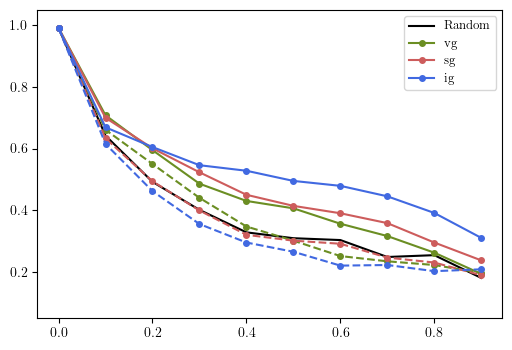

In [7]:
colors = ['olivedrab', 'indianred', 'royalblue', 'black']
labels = ['vg', 'sg', 'ig']
full_acc = [0.9915]  # Accuracy of CNN on MNIST without perturbation
# full_acc = [0.9439]  # Accuracy of WRN40_4 on CIFAR10 without perturbation
ratios = np.linspace(0, 1, 11)[:-1]

plot_title = 'CIFAR10 - WideResNet'

fig, ax = plt.subplots(figsize=(6, 4))
random_refs = full_acc + random_baseline
ax.plot(ratios, random_refs, linestyle='-', color=colors[-1], label='Random')

marker, s = '.', 8
for idx, lbl in enumerate(labels):
    c = colors[idx]
    accs = full_acc + kaft_results[lbl]
    ax.plot(ratios, accs, linestyle='-', marker=marker, markersize=s, color=c, label=lbl)

    accs = full_acc + raftAbs_results[lbl]
    ax.plot(ratios, accs, linestyle='--', marker=marker, markersize=s, color=c,)
ax.set_ylim(0.05, 1.05)
ax.legend(fontsize=9)

The above results generally align with the observation reported in Figure 5. 
Repeat the process with different random seeds (including 1. the randomness by dataset downsampling during explanation; 2. the randomness during model retraining) to reproduce the exact resutls.

In [8]:
for lbl in labels:
    kaft_accs = kaft_results[lbl]
    raftAbs_accs = raftAbs_results[lbl]
    delta_acc = np.mean(kaft_accs) - np.mean(raftAbs_accs)
    delta_acc *= 100    # in percentage
    log(f'{lbl} -- ∆Acc.: [{delta_acc:.2f}]')

INFO[11/17/25,17:38:56]:	vg -- ∆Acc.: [6.11]
INFO[11/17/25,17:38:56]:	sg -- ∆Acc.: [9.61]
INFO[11/17/25,17:38:56]:	ig -- ∆Acc.: [18.04]
